In [80]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.gridspec as gridspec
import textwrap
import os
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import numpy as np
import seaborn as sns

column_time = 'TimeIndice'
time_series_columns = ['HeartRate', 'VelocityX', 'VelocityY', 'VelocityZ', 'RotationX', 'RotationY', 'RotationZ']

def load_data(file_path, column_time):
    df = pd.read_csv(file_path)
    
    # Remove rows where TimeIndice is NaN
    df = df[df[column_time].notna()]
    
    # Convert all string columns to lowercase
    df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
    
    return df

def extract_timestamps(df, column_time, record_index):
    series_time = df[column_time].iloc[record_index]
    timestamps = [datetime.strptime(x.strip(), '%H:%M:%S.%f') for x in series_time.split(';') if x.strip()]
    
    return timestamps

def plot_data(df, timestamps, columns, record_index):
    n = len(columns)
    n_rows = (n + 1) // 2
    
    gs = gridspec.GridSpec(n_rows + 1, 2, height_ratios=[0.1] + [1]*n_rows)
    fig = plt.figure(figsize=(20, 2.5 * (n_rows + 1)))
    
    ax_text = fig.add_subplot(gs[0, :])
    ax_text.axis('off')
    
    all_columns = set(df.columns)
    plottable_columns = set(columns + [column_time])
    info_columns = list(all_columns - plottable_columns)
    
    if info_columns:
        info_text = "\t\t".join([f"{col}: {df[col].iloc[record_index]}" for col in info_columns])
        wrapped_text = textwrap.fill(info_text, width=220)
        ax_text.text(0, 0.5, wrapped_text, ha='left', va='center', fontsize=13)
    
    axs = [fig.add_subplot(gs[i+1, j]) for i in range(n_rows) for j in range(2)]
    
    for idx, ax in enumerate(axs[:n]):
        column = columns[idx]
        series_data = df[column].iloc[record_index]
        data_values = [float(x.strip()) for x in series_data.split(';') if x.strip()]

        ax.plot(timestamps, data_values, label=column)
        ax.set_title(column)
        ax.set_xlabel('Time Index')
        ax.set_ylabel('Data Values')
        ax.grid(True)
        ax.legend()
        
    if n % 2 != 0:
        axs[-1].axis('off')
        
    plt.tight_layout()
    plt.show()

def plot_smooth_data(df, timestamps, columns, record_index, smoothness):
    n = len(columns)
    n_rows = (n + 1) // 2
    
    gs = gridspec.GridSpec(n_rows + 1, 2, height_ratios=[0.1] + [1]*n_rows)
    fig = plt.figure(figsize=(20, 2.5 * (n_rows + 1)))
    
    ax_text = fig.add_subplot(gs[0, :])
    ax_text.axis('off')
    
    all_columns = set(df.columns)
    plottable_columns = set(columns + [column_time])
    info_columns = list(all_columns - plottable_columns)
    
    if info_columns:
        info_text = "\t\t".join([f"{col}: {df[col].iloc[record_index]}" for col in info_columns])
        wrapped_text = textwrap.fill(info_text, width=220)
        ax_text.text(0, 0.5, wrapped_text, ha='left', va='center', fontsize=13)
    
    axs = [fig.add_subplot(gs[i+1, j]) for i in range(n_rows) for j in range(2)]
    
    for idx, ax in enumerate(axs[:n]):
        column = columns[idx]
        series_data = df[column].iloc[record_index]
        data_values = [float(x.strip()) for x in series_data.split(';') if x.strip()]

        # Create a cubic spline interpolation of the data
        spline = UnivariateSpline(range(len(data_values)), data_values, s=smoothness)
        x_new = np.linspace(0, len(data_values) - 1, 1000)
        y_new = spline(x_new)

        ax.plot(x_new, y_new, label=column)
        ax.set_title(column)
        ax.set_xlabel('Time Index')
        ax.set_ylabel('Data Values')
        ax.grid(True)
        ax.legend()
        
    if n % 2 != 0:
        axs[-1].axis('off')
        
    plt.tight_layout()
    plt.show()

def delete_record_and_save_to_csv(df, record_index, csv_filename):
    df = df.drop(index=record_index)
    df.to_csv(csv_filename, index=False)

# Get a list of CSV files in the current directory
csv_files = [file for file in os.listdir('./') if file.endswith('.csv')]

# Initialize an empty dataframe to store concatenated data
all_data = pd.DataFrame()

# Iterate over CSV files and concatenate them
for file_path in csv_files:
    if file_path != 'all_data.csv':
        df = load_data(file_path, column_time)
        all_data = pd.concat([all_data, df], ignore_index=True)

# Load the original data from all_data.csv
original_data = load_data('all_data.csv', column_time)

# Append the data from other CSV files to all_data
all_data = pd.concat([original_data, all_data], ignore_index=True)

# Remove duplicates based on the "Id" column in all_data
all_data = all_data.drop_duplicates(subset=['Id'])

# Sort the concatenated dataframe based on the "Id" column
all_data['Id'] = pd.to_datetime(all_data['Id'])
all_data = all_data.sort_values(by='Id')

# Reset the index after sorting
all_data = all_data.reset_index(drop=True)

# Save the updated all_data to all_data.csv
all_data.to_csv('all_data.csv', index=False)


In [81]:
record_index = 319

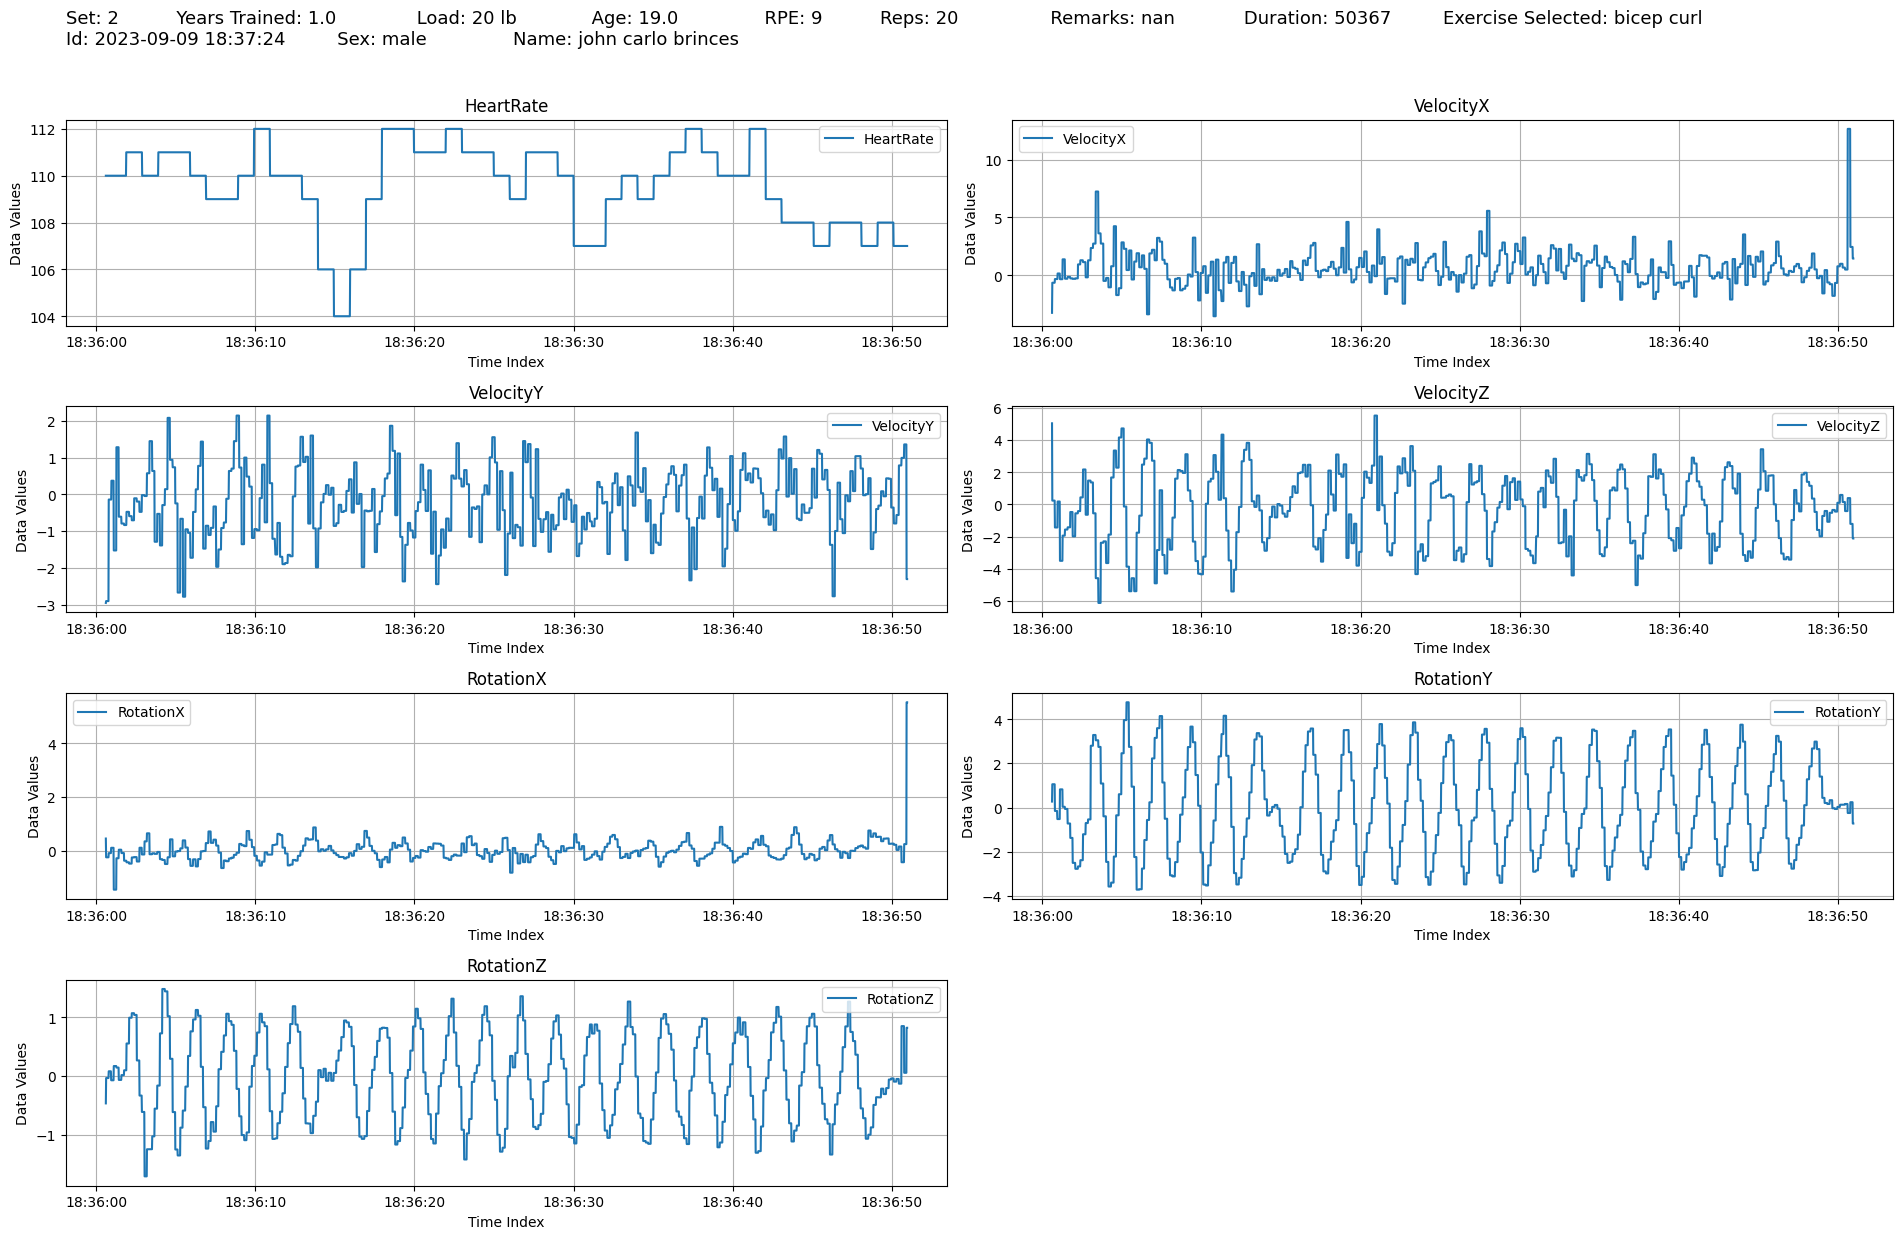

In [82]:
# Extract timestamps and plot the data
timestamps = extract_timestamps(all_data, column_time, record_index)
plot_data(all_data, timestamps, time_series_columns, record_index)



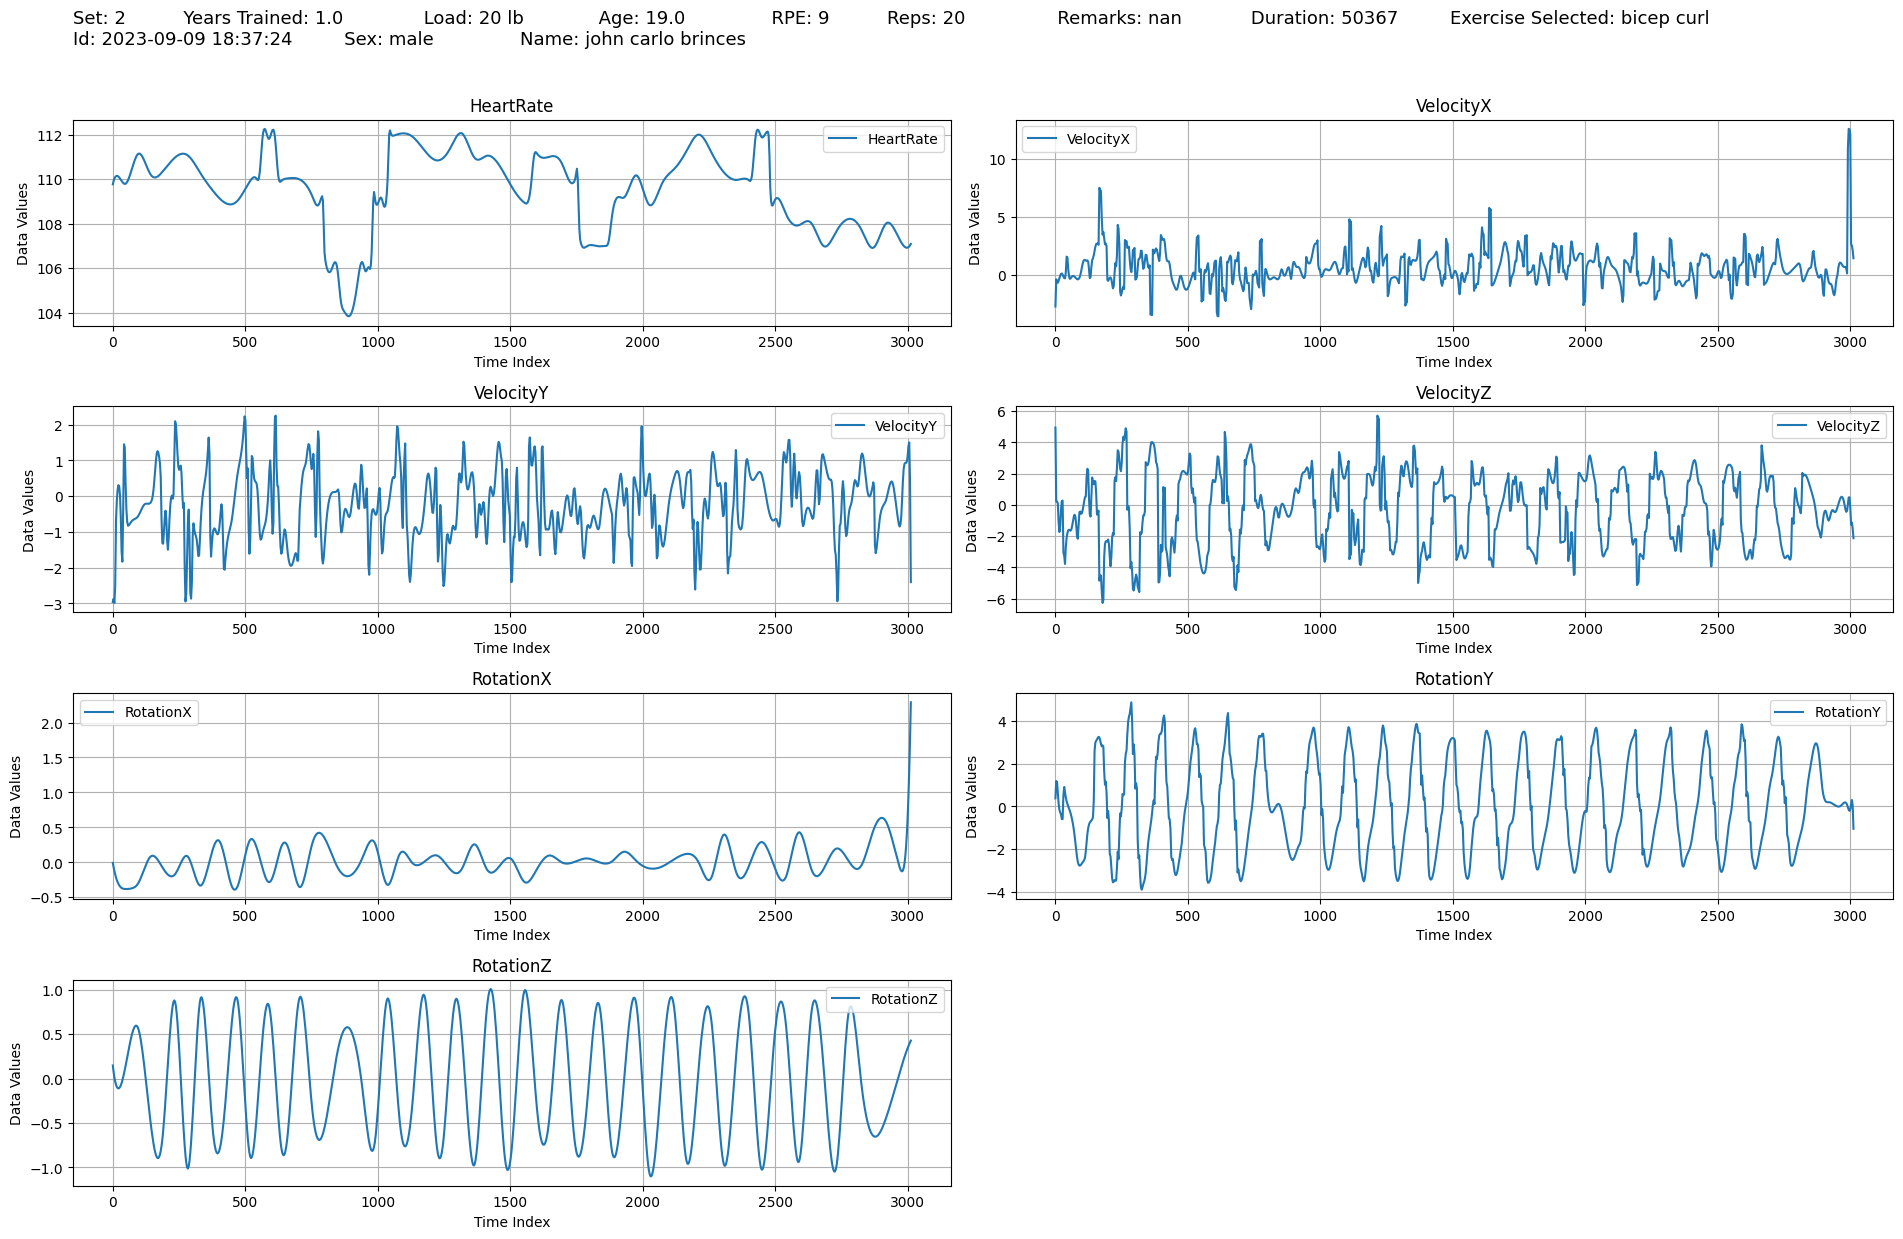

In [83]:
plot_smooth_data(all_data, timestamps, time_series_columns, record_index, 200)

In [84]:
#all_data = all_data.drop(all_data.index[:10])
#all_data.to_csv('all_data.csv', index=False)

In [85]:
#delete_record_and_save_to_csv(all_data, 3, 'all_data.csv')

In [86]:
filtered_df = all_data[all_data['Remarks'].notnull()]

# Display only the "Remarks" column
print(filtered_df['Remarks'])


15                  hello world
16                  hello world
17                   late start
107                      sitted
108                      sitted
109                      sitted
110                       cable
111                       cable
125               improper form
132               improper form
133    improper form at the end
139                 late record
144                   bench 1st
168     change firdt set to 3!4
233           technogym machine
236                    dropset 
255                  cross body
256                       cross
339                   technogym
344                  incomplete
345                 experienced
357                   technogym
358                   technogym
378      change experience to 1
Name: Remarks, dtype: object


In [87]:
print(all_data['Name'].unique())

['kalki lamadrid' 'lhyn mae' 'jom comedia' 'deuz amparo' 'andreb trofeo'
 'raha pullon' 'bryan quidlat' 'josh cabrera' 'jan bush azuela'
 'andrea calayan' 'kenn ballesteros' 'rianne alvarez' 'kim alfaro'
 'ronn angkico' 'sean bartolome' 'doreen mendoza' 'dewey cabasaan'
 'lou ballesteros' 'john carlo brinces' 'keith gerard anciro'
 'jayden reyes']


In [88]:
all_data.loc[:, 'Exercise Selected'] = all_data.loc[:, 'Exercise Selected'].replace('squat', 'hammer curl')
all_data.loc[:, 'Exercise Selected'] = all_data.loc[:, 'Exercise Selected'].replace('cross body hammer curl', 'hammer curl')
all_data.loc[:, 'Exercise Selected'] = all_data.loc[:, 'Exercise Selected'].replace('deadlift', 'lat pulldown')
all_data.loc[:, 'Exercise Selected'] = all_data.loc[:, 'Exercise Selected'].replace('tricep kickback', 'tricep pushdown')
all_data.loc[:, 'Exercise Selected'] = all_data.loc[:, 'Exercise Selected'].replace('triceps pushdown', 'tricep pushdown')
all_data.loc[:, 'Exercise Selected'] = all_data.loc[:, 'Exercise Selected'].replace('lunges', 'chest fly')

In [89]:
all_data['Name'] = all_data['Name'].replace('kalki', 'kalki lamadrid')
all_data['Name'] = all_data['Name'].replace('duwi', 'dewey cabasaan')
all_data['Name'] = all_data['Name'].replace('doreen', 'doreen mendoza')
all_data['Name'] = all_data['Name'].replace('keith', 'keith gerard anciro')
all_data['Name'] = all_data['Name'].replace('jayden', 'jayden reyes')
all_data['Name'] = all_data['Name'].replace('ronn', 'ronn angkico')

In [90]:
all_data.to_csv('all_data.csv', index=False)

In [91]:
dfPage = 4
all_data.loc[dfPage*50:(dfPage+1)*50,['Set', 'Name', 'Exercise Selected', 'Load', 'Reps', 'RPE', 'Remarks', 'Duration', 'Id','Years Trained']]

,Set,Name,Exercise Selected,Load,Reps,RPE,Remarks,Duration,Id,Years Trained
200,3,rianne alvarez,chest fly,121 lb,8,9.5,NaN,40912,2023-09-07 18:18:37,1.0
201,1,kim alfaro,bench press,16 lb,20,7,NaN,61636,2023-09-08 14:46:22,1.0
202,2,kim alfaro,bench press,10 kg,12,8,NaN,21576,2023-09-08 14:48:59,1.0
203,3,kim alfaro,bench press,10 kg,10,8,NaN,24138,2023-09-08 14:50:52,1.0
204,1,kim alfaro,shoulder press,16 lb,14,8.5,NaN,33747,2023-09-08 14:54:42,1.0
205,2,kim alfaro,shoulder press,16 lb,10,9,NaN,20470,2023-09-08 14:55:44,1.0
206,3,kim alfaro,shoulder press,16 lb,8,9.5,NaN,18530,2023-09-08 14:57:33,1.0
207,1,kim alfaro,bicep curl,16 lb,15,9,NaN,35661,2023-09-08 14:59:35,1.0
208,2,kim alfaro,bicep curl,16 lb,10,9.5,NaN,24822,2023-09-08 15:01:43,1.0
209,3,kim alfaro,bicep curl,16 lb,8,10,NaN,17791,2023-09-08 15:03:45,1.0
